# readme
descrip: plot sfc vel (V0) in Gulf of Maine and Gulf of Mexico for historic and future time periods <br>

update history: <br>
v1.0 DL 2021Feb06 <br>
v1.1 DL 2021Mar03 <br>
v1.2 DL 2021Apr24 <br>
v1.3 DL 2021May06 make publication-ready pics <br>
v1.4 DL 2021May20 combine TR run results into one fig (for main text) and control run results into one fig (support info) <br>
v1.5 DL 2021Jun02 pivot to CESM-HR special volume paper, use TR minus CN to account for the model drift <br>
 
extra notes: <br>
Fig 3 of the CESM-HR specital volume paper <br>

# import modules

In [1]:
# general python packages
import numpy as np
from scipy import stats
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
# import matplotlib.dates as mdates
%matplotlib inline
import proplot as plot
import cartopy
# import cartopy.crs as ccrs
cartopy.config['pre_existing_data_dir']='/ihesp/shared/cartopy_features'
# from cartopy.mpl.geoaxes import GeoAxes
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
# from mpl_toolkits.axes_grid1 import AxesGrid
import glob

# python GCM(POP) packages
# import xgcm
# import pop_tools
# import xoak
# import xesmf as xe

# dask jupyter lab packages
from dask.distributed import Client
# from dask.distributed import performance_report

# file name with time packages
# from itertools import product
# from cftime import DatetimeNoLeap

# incorporate dask 

In [2]:
client = Client("tcp://10.73.3.129:36327")
client

<Client: 'tcp://10.73.3.129:36327' processes=16 threads=16, memory=316.64 GiB>

# define parameters

In [3]:
# === r: region (US east coast excluding Gulf of Mexico) ===
# reference: Plot2FindGulfMexicoYucatanChannelFLstraitnlatnlonIndex_2021Jul20.ipynb
nlon1_r_t12, nlon2_r_t12 = 200, 700 
nlat1_r_t12, nlat2_r_t12 = 1300, 2000

nlon1_r_g16, nlon2_r_g16 = 260, 321
nlat1_r_g16, nlat2_r_g16 = 230, 350

lon1_r, lon2_r = -85, -50
lat1_r, lat2_r = 25, 55

# box1 (bx1), southeast US coast box
lon1_bx1, lon2_bx1 = -82, -79
lat1_bx1, lat2_bx1 = 30, 33
# box2 (bx2), northeast US coast box
lon1_bx2, lon2_bx2 = -71, -68
lat1_bx2, lat2_bx2 = 40.5, 43.5
# ===========================================================

z = 15*100 # 15 m 
# z = 2000*100 # 2000 m 

chunks_HR = {'nlat':400,'nlon':300,'z_t':1}
chunks_LR = {'nlat':384,'nlon':320/5,'z_t':1}

# === POP grids files ===
infile_g16 = ('/ihesp/user/dapengli/Projects4iHESP/'
'SupplementaryFiles4POP/POPgrids_gx1v6_2020Jun29.nc') # POP g16 grid file
infile_t12 = ('/ihesp/user/dapengli/Projects4iHESP/'
'SupplementaryFiles4POP/POPgrids_tx0.1v2_2020Jun29.nc') # POP t12 grid file
# =======================

outdir = '/scratch/user/dapengli/Projects4iHESP/Project_SeaLevelUSEastCoast_2021Mar30/pics/'
pic1 = outdir + 'SfcVelAMOCregressionUSEastCoastCESM_2021Sep29.png'

# read data files

In [4]:
# read TH U, V vel

# 'B.E.13.BHISTC5.ne120_t12.sehires38.003.sunway.pop.h.TEMP.192801-192812.nc'
yrs1a_TH = np.arange(2001,2005+1) 
prefix1a_TH = 'B.E.13.BHISTC5.ne120_t12.sehires38.003.sunway.pop.h.'

indir1a_uvel_TH = ('/ihesp/archive/B.E.13.BHISTC5.ne120_t12.sehires38.003.sunway/ocn/proc/tseries/month_1/UVEL/')
infiles1a_uvel_TH = [indir1a_uvel_TH + prefix1a_TH + 'UVEL.' + str(iyr) + '01-' + str(iyr) + '12.nc' 
               for iyr in yrs1a_TH]
infiles1a_uvel_TH

indir1a_vvel_TH = ('/ihesp/archive/B.E.13.BHISTC5.ne120_t12.sehires38.003.sunway/ocn/proc/tseries/month_1/VVEL/')
infiles1a_vvel_TH = [indir1a_vvel_TH + prefix1a_TH + 'VVEL.' + str(iyr) + '01-' + str(iyr) + '12.nc' 
               for iyr in yrs1a_TH]
infiles1a_vvel_TH


yrs2_TH = np.arange(2006,2100+1)
prefix2_TH = 'B.E.13.BRCP85C5CN.ne120_t12.sehires38.003.sunway.CN_OFF.pop.h.'
indir1b_uvel_TH = ('/ihesp/archive/B.E.13.BRCP85C5CN.ne120_t12.sehires38.003.sunway.CN_OFF/ocn/proc/tseries/month_1/UVEL/')
infiles2_uvel_TH = [indir1b_uvel_TH + prefix2_TH + 'UVEL.' + str(iyr) + '01-' + str(iyr) + '12.nc' 
               for iyr in yrs2_TH]
infiles2_uvel_TH

indir1b_vvel_TH = ('/ihesp/archive/B.E.13.BRCP85C5CN.ne120_t12.sehires38.003.sunway.CN_OFF/ocn/proc/tseries/month_1/VVEL/')
infiles2_vvel_TH = [indir1b_vvel_TH + prefix2_TH + 'VVEL.' + str(iyr) + '01-' + str(iyr) + '12.nc' 
               for iyr in yrs2_TH]
infiles2_vvel_TH


ds_uvel_TH = xr.open_mfdataset(infiles1a_uvel_TH + infiles2_uvel_TH, compat="override", combine="by_coords", 
                       data_vars="minimal", coords="minimal", chunks=chunks_HR, 
                       parallel=True)

ds_vvel_TH = xr.open_mfdataset(infiles1a_vvel_TH + infiles2_vvel_TH, compat="override", combine="by_coords", 
                       data_vars="minimal", coords="minimal", chunks=chunks_HR, 
                       parallel=True)
ds_vvel_TH 

<xarray.Dataset>
Dimensions:             (d2: 2, nlat: 2400, nlon: 3600, time: 1200, z_t: 62, z_t_150m: 15, z_w: 62, z_w_bot: 62, z_w_top: 62)
Coordinates:
  * z_t                 (z_t) float32 500.0 1.5e+03 ... 5.625e+05 5.875e+05
  * z_t_150m            (z_t_150m) float32 500.0 1.5e+03 ... 1.35e+04 1.45e+04
  * z_w                 (z_w) float32 0.0 1e+03 2e+03 ... 5.5e+05 5.75e+05
  * z_w_top             (z_w_top) float32 0.0 1e+03 2e+03 ... 5.5e+05 5.75e+05
  * z_w_bot             (z_w_bot) float32 1e+03 2e+03 3e+03 ... 5.75e+05 6e+05
    ULONG               (nlat, nlon) float64 dask.array<chunksize=(400, 300), meta=np.ndarray>
    ULAT                (nlat, nlon) float64 dask.array<chunksize=(400, 300), meta=np.ndarray>
    TLONG               (nlat, nlon) float64 dask.array<chunksize=(400, 300), meta=np.ndarray>
    TLAT                (nlat, nlon) float64 dask.array<chunksize=(400, 300), meta=np.ndarray>
  * time                (time) object 2001-02-01 00:00:00 ... 2101-01-01 00:0...
Dimensions without coordinates: d2, nlat, nlon
Data variables: (12/51)
    dz                  (z_t) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    dzw                 (z_w) float32 dask.array<chunksize=(62,), meta=np.ndarray>
    KMT                 (nlat, nlon) float64 dask.array<chunksize=(400, 300), meta=np.ndarray>
    KMU                 (nlat, nlon) float64 dask.array<chunksize=(400, 300), meta=np.ndarray>
    REGION_MASK         (nlat, nlon) float64 dask.array<chunksize=(400, 300), meta=np.ndarray>
    UAREA               (nlat, nlon) float64 dask.array<chunksize=(400, 300), meta=np.ndarray>
    ...                  ...
    salinity_factor     float64 ...
    sflux_factor        float64 ...
    nsurface_t          float64 ...
    nsurface_u          float64 ...
    time_bound          (time, d2) object dask.array<chunksize=(12, 2), meta=np.ndarray>
    VVEL                (time, z_t, nlat, nlon) float32 dask.array<chunksize=(12, 1, 400, 300), meta=np.ndarray>
Attributes:
    title:         B.E.13.BHISTC5.ne120_t12.sehires38.003.sunway
    history:       Thu Aug 26 14:23:01 2021: ncap2 -A -s time=udunits(time, "...
    Conventions:   CF-1.0; http://www.cgd.ucar.edu/cms/eaton/netcdf/CF-curren...
    contents:      Diagnostic and Prognostic Variables
    source:        CCSM POP2, the CCSM Ocean Component
    revision:      $Id: tavg.F90 56176 2013-12-20 18:35:46Z mlevy@ucar.edu $
    calendar:      All years have exactly  365 days.
    start_time:    This dataset was created on 2020-03-16 at 08:33:13.4
    cell_methods:  cell_methods = time: mean ==> the variable values are aver...
    nsteps_total:  34411091
    tavg_sum:      2678400.0
    NCO:           netCDF Operators version 4.8.1 (Homepage = http://nco.sf.n...

In [5]:
# read CH U, V vel

# 'B.E.13.BHISTC5.ne120_t12.sehires38.003.sunway.pop.h.TEMP.192801-192812.nc'
yrs1a_CH = np.arange(401,500+1) 
prefix1a_CH = 'B.E.13.B1850C5.ne120_t12.sehires38.003.sunway_02.pop.h.'

indir1a_uvel_CH = ('/ihesp/archive/B.E.13.B1850C5.ne120_t12.sehires38.003.sunway_02/ocn/proc/UVEL/')
infiles1a_uvel_CH = [indir1a_uvel_CH + prefix1a_CH + 'UVEL.' + str(iyr).zfill(4) +'01-' + str(iyr).zfill(4)+ '12.nc'
                     for iyr in yrs1a_CH]
infiles1a_uvel_CH

indir1a_vvel_CH = ('/ihesp/archive/B.E.13.B1850C5.ne120_t12.sehires38.003.sunway_02/ocn/proc/VVEL/')
infiles1a_vvel_CH = [indir1a_vvel_CH + prefix1a_CH + 'VVEL.' + str(iyr).zfill(4) +'01-' + str(iyr).zfill(4)+ '12.nc'
               for iyr in yrs1a_CH]
infiles1a_vvel_CH

ds_uvel_CH = xr.open_mfdataset(infiles1a_uvel_CH, compat="override", combine="by_coords", 
                       data_vars="minimal", coords="minimal", chunks=chunks_HR, 
                       parallel=True)

ds_vvel_CH = xr.open_mfdataset(infiles1a_vvel_CH, compat="override", combine="by_coords", 
                       data_vars="minimal", coords="minimal", chunks=chunks_HR, 
                       parallel=True)
ds_vvel_CH 

<xarray.Dataset>
Dimensions:             (d2: 2, nlat: 2400, nlon: 3600, time: 1200, z_t: 62, z_t_150m: 15, z_w: 62, z_w_bot: 62, z_w_top: 62)
Coordinates:
  * z_t                 (z_t) float32 500.0 1.5e+03 ... 5.625e+05 5.875e+05
  * z_t_150m            (z_t_150m) float32 500.0 1.5e+03 ... 1.35e+04 1.45e+04
  * z_w                 (z_w) float32 0.0 1e+03 2e+03 ... 5.5e+05 5.75e+05
  * z_w_top             (z_w_top) float32 0.0 1e+03 2e+03 ... 5.5e+05 5.75e+05
  * z_w_bot             (z_w_bot) float32 1e+03 2e+03 3e+03 ... 5.75e+05 6e+05
    ULONG               (nlat, nlon) float64 dask.array<chunksize=(400, 300), meta=np.ndarray>
    ULAT                (nlat, nlon) float64 dask.array<chunksize=(400, 300), meta=np.ndarray>
    TLONG               (nlat, nlon) float64 dask.array<chunksize=(400, 300), meta=np.ndarray>
    TLAT                (nlat, nlon) float64 dask.array<chunksize=(400, 300), meta=np.ndarray>
  * time                (time) object 0401-02-01 00:00:00 ... 0501-01-01 00:0...
Dimensions without coordinates: d2, nlat, nlon
Data variables: (12/51)
    dz                  (z_t) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    dzw                 (z_w) float32 dask.array<chunksize=(62,), meta=np.ndarray>
    KMT                 (nlat, nlon) float64 dask.array<chunksize=(400, 300), meta=np.ndarray>
    KMU                 (nlat, nlon) float64 dask.array<chunksize=(400, 300), meta=np.ndarray>
    REGION_MASK         (nlat, nlon) float64 dask.array<chunksize=(400, 300), meta=np.ndarray>
    UAREA               (nlat, nlon) float64 dask.array<chunksize=(400, 300), meta=np.ndarray>
    ...                  ...
    salinity_factor     float64 ...
    sflux_factor        float64 ...
    nsurface_t          float64 ...
    nsurface_u          float64 ...
    time_bound          (time, d2) object dask.array<chunksize=(12, 2), meta=np.ndarray>
    VVEL                (time, z_t, nlat, nlon) float32 dask.array<chunksize=(12, 1, 400, 300), meta=np.ndarray>
Attributes:
    title:         B.E.13.B1850C5.ne120_t12.sehires38.003.sunway_02
    history:       Sat Jul 24 15:04:58 2021: ncap2 -A -s time=udunits(time, "...
    Conventions:   CF-1.0; http://www.cgd.ucar.edu/cms/eaton/netcdf/CF-curren...
    contents:      Diagnostic and Prognostic Variables
    source:        CCSM POP2, the CCSM Ocean Component
    revision:      $Id: tavg.F90 56176 2013-12-20 18:35:46Z mlevy@ucar.edu $
    calendar:      All years have exactly  365 days.
    start_time:    This dataset was created on 2020-01-03 at 01:54:07.7
    cell_methods:  cell_methods = time: mean ==> the variable values are aver...
    nsteps_total:  86568131
    tavg_sum:      2678400.0
    NCO:           netCDF Operators version 4.8.1 (Homepage = http://nco.sf.n...

In [6]:
# read TL U, V vel
indir1_TL = ('/ihesp/archive/'
          'B.E.13.BHISTC5.ne30g16.sehires38.003.sunway/ocn/monthly/')
infiles1_TL = sorted(glob.glob(indir1_TL+'cmpr_B.E.13.BHISTC5.ne30g16.sehires38.003.sunway.pop.h.200[1-5]-??.nc'))

indir2_TL = ('/ihesp/archive/'
          'B.E.13.BRCP85C5CN.ne30g16.sehires38.003.sunway.CN_OFF/ocn/monthly/')
infiles2a_TL = sorted(glob.glob(indir2_TL+'cmpr_B.E.13.BRCP85C5CN.ne30g16.sehires38.003.sunway.CN_OFF.pop.h.20??-??.nc'))

infiles2b_TL = sorted(glob.glob(indir2_TL+'cmpr_B.E.13.BRCP85C5CN.ne30g16.sehires38.003.sunway.CN_OFF.pop.h.2100-??.nc')) # add year 2100, 
infiles_TL = infiles1_TL + infiles2a_TL + infiles2b_TL
print(infiles_TL[0])
print(infiles_TL[-1])

ds0_TL=xr.open_dataset(infiles2a_TL[0])

keeplist=['UVEL','VVEL','time','z_t','ULONG','ULAT']

droplist_TL=list(ds0_TL.variables)
for i in keeplist:
    droplist_TL.remove(i)
# droplist
droplist_TL = droplist_TL + ['CFC_IFRAC','CFC_XKW','CFC_ATM_PRESS','CFC11','STF_CFC11','CFC12','STF_CFC12']
# HIST and RCP85 have different outputs, add more variables to droplist
print(droplist_TL)

ds_TL = xr.open_mfdataset(infiles_TL, compat="override", combine="by_coords", 
                       data_vars="minimal", coords="minimal", chunks=chunks_LR, 
                       drop_variables=droplist_TL, parallel=True)
ds_TL

/ihesp/archive/B.E.13.BHISTC5.ne30g16.sehires38.003.sunway/ocn/monthly/cmpr_B.E.13.BHISTC5.ne30g16.sehires38.003.sunway.pop.h.2001-01.nc
/ihesp/archive/B.E.13.BRCP85C5CN.ne30g16.sehires38.003.sunway.CN_OFF/ocn/monthly/cmpr_B.E.13.BRCP85C5CN.ne30g16.sehires38.003.sunway.CN_OFF.pop.h.2100-12.nc
['z_t_150m', 'z_w', 'z_w_top', 'z_w_bot', 'lat_aux_grid', 'moc_z', 'time_bound', 'moc_components', 'transport_components', 'transport_regions', 'dz', 'dzw', 'TLONG', 'TLAT', 'KMT', 'KMU', 'REGION_MASK', 'UAREA', 'TAREA', 'HU', 'HT', 'DXU', 'DYU', 'DXT', 'DYT', 'HTN', 'HTE', 'HUS', 'HUW', 'ANGLE', 'ANGLET', 'days_in_norm_year', 'grav', 'omega', 'radius', 'cp_sw', 'sound', 'vonkar', 'cp_air', 'rho_air', 'rho_sw', 'rho_fw', 'stefan_boltzmann', 'latent_heat_vapor', 'latent_heat_fusion', 'ocn_ref_salinity', 'sea_ice_salinity', 'T0_Kelvin', 'salt_to_ppt', 'ppt_to_salt', 'mass_to_Sv', 'heat_to_PW', 'salt_to_Svppt', 'salt_to_mmday', 'momentum_factor', 'hflux_factor', 'fwflux_factor', 'salinity_factor', 's

<xarray.Dataset>
Dimensions:  (nlat: 384, nlon: 320, time: 1199, z_t: 60)
Coordinates:
  * time     (time) object 2001-02-01 00:00:00 ... 2101-01-01 00:00:00
  * z_t      (z_t) float32 500.0 1.5e+03 2.5e+03 ... 5.125e+05 5.375e+05
    ULONG    (nlat, nlon) float64 dask.array<chunksize=(384, 64), meta=np.ndarray>
    ULAT     (nlat, nlon) float64 dask.array<chunksize=(384, 64), meta=np.ndarray>
Dimensions without coordinates: nlat, nlon
Data variables:
    UVEL     (time, z_t, nlat, nlon) float32 dask.array<chunksize=(1, 1, 384, 64), meta=np.ndarray>
    VVEL     (time, z_t, nlat, nlon) float32 dask.array<chunksize=(1, 1, 384, 64), meta=np.ndarray>
Attributes:
    title:         B.E.13.BHISTC5.ne30g16.sehires38.003.sunway
    history:       none
    Conventions:   CF-1.0; http://www.cgd.ucar.edu/cms/eaton/netcdf/CF-curren...
    contents:      Diagnostic and Prognostic Variables
    source:        CCSM POP2, the CCSM Ocean Component
    revision:      $Id: tavg.F90 56176 2013-12-20 18:35:46Z mlevy@ucar.edu $
    calendar:      All years have exactly  365 days.
    start_time:    This dataset was created on 2020-04-29 at 09:51:46.0
    cell_methods:  cell_methods = time: mean ==> the variable values are aver...
    nsteps_total:  1378625
    tavg_sum:      2678400.0

In [7]:
# read CL U, V  vel
indir_CL = ('/ihesp/archive/'
          'B.E.13.B1850C5.ne30g16.sehires38.003.sunway/ocn/monthly/')
infiles1a_CL = sorted(glob.glob(indir_CL+'cmpr_B.E.13.B1850C5.ne30g16.sehires38.003.sunway.pop.h.04??-??.nc'))
del infiles1a_CL[0:11+1] # remove year 400

infiles1b_CL = sorted(glob.glob(indir_CL+'cmpr_B.E.13.B1850C5.ne30g16.sehires38.003.sunway.pop.h.0500-??.nc')) # add year 500, 
infiles_CL = infiles1a_CL + infiles1b_CL
print(infiles_CL[0])
print(infiles_CL[-1])

ds0_CL=xr.open_dataset(infiles_CL[0])

keeplist=['UVEL','VVEL','time','z_t','ULONG','ULAT']

droplist_CL=list(ds0_CL.variables)
for i in keeplist:
    droplist_CL.remove(i)
# droplist

ds_CL = xr.open_mfdataset(infiles_CL, compat="override", combine="by_coords", 
                       data_vars="minimal", coords="minimal", chunks=chunks_LR, 
                       drop_variables=droplist_CL, parallel=True)
ds_CL

/ihesp/archive/B.E.13.B1850C5.ne30g16.sehires38.003.sunway/ocn/monthly/cmpr_B.E.13.B1850C5.ne30g16.sehires38.003.sunway.pop.h.0401-01.nc
/ihesp/archive/B.E.13.B1850C5.ne30g16.sehires38.003.sunway/ocn/monthly/cmpr_B.E.13.B1850C5.ne30g16.sehires38.003.sunway.pop.h.0500-12.nc


<xarray.Dataset>
Dimensions:  (nlat: 384, nlon: 320, time: 1197, z_t: 60)
Coordinates:
  * time     (time) object 0401-02-01 00:00:00 ... 0501-01-01 00:00:00
  * z_t      (z_t) float32 500.0 1.5e+03 2.5e+03 ... 5.125e+05 5.375e+05
    ULONG    (nlat, nlon) float64 dask.array<chunksize=(384, 64), meta=np.ndarray>
    ULAT     (nlat, nlon) float64 dask.array<chunksize=(384, 64), meta=np.ndarray>
Dimensions without coordinates: nlat, nlon
Data variables:
    UVEL     (time, z_t, nlat, nlon) float32 dask.array<chunksize=(1, 1, 384, 64), meta=np.ndarray>
    VVEL     (time, z_t, nlat, nlon) float32 dask.array<chunksize=(1, 1, 384, 64), meta=np.ndarray>
Attributes:
    title:         B.E.13.B1850C5.ne30g16.sehires38.003.sunway
    history:       none
    Conventions:   CF-1.0; http://www.cgd.ucar.edu/cms/eaton/netcdf/CF-curren...
    contents:      Diagnostic and Prognostic Variables
    source:        CCSM POP2, the CCSM Ocean Component
    revision:      $Id: tavg.F90 56176 2013-12-20 18:35:46Z mlevy@ucar.edu $
    calendar:      All years have exactly  365 days.
    start_time:    This dataset was created on 2020-04-28 at 19:05:54.5
    cell_methods:  cell_methods = time: mean ==> the variable values are aver...
    nsteps_total:  3650750
    tavg_sum:      2678400.0

In [8]:
infile_MOC_TH = ('/ihesp/archive/Sunway_Runs/HR_HF_TNST/'
                 'B.E.13.BTRANS.ne120_t12.sehires38.003.sunway.pop.h.MOC.185001.210012.nc')

ds_MOC_TH = xr.open_dataset(infile_MOC_TH)
time_s_TH = ds_MOC_TH.time.to_pandas().index.shift(-1,'M') # shift 1 mon
ds_MOC_TH = ds_MOC_TH.assign_coords(time=time_s_TH)
ds_MOC_TH

<xarray.Dataset>
Dimensions:            (lat_aux_grid: 395, moc_comp: 1, moc_z: 63, time: 3012, transport_reg: 2)
Coordinates:
  * time               (time) object 1850-01-31 00:00:00 ... 2100-12-31 00:00:00
    transport_regions  (transport_reg) |S256 ...
    moc_components     (moc_comp) |S256 ...
  * moc_z              (moc_z) float32 0.0 1e+03 2e+03 ... 5.75e+05 6e+05
  * lat_aux_grid       (lat_aux_grid) float32 -79.49 -78.95 ... 89.47 90.0
Dimensions without coordinates: moc_comp, transport_reg
Data variables:
    MOC                (time, transport_reg, moc_comp, moc_z, lat_aux_grid) float32 ...

In [9]:
infile_MOC_CH = ('/ihesp/archive/Sunway_Runs/HR_PI_CTRL/'
                 'B.E.13.B1850C5.ne120_t12.sehires38.003.sunway_02.pop.h.MOC.002101.050112.nc')

ds_MOC_CH = xr.open_dataset(infile_MOC_CH)
print(ds_MOC_CH.time)
# 250-->1850, 500-->2100
# 1-->1601, # 1850-(250-1)=1601
# 21-->1621,  501-->2101, 1850-(250-21)=1621
time_MOC_CH = xr.cftime_range(start="1621-01", end="2102-01", freq='M', calendar='noleap') 
ds_MOC_CH = ds_MOC_CH.assign_coords(time=time_MOC_CH)
ds_MOC_CH

<xarray.DataArray 'time' (time: 5772)>
array([cftime.DatetimeNoLeap(21, 2, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(21, 3, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(21, 4, 1, 0, 0, 0, 0, has_year_zero=True), ...,
       cftime.DatetimeNoLeap(501, 11, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(501, 12, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(502, 1, 1, 0, 0, 0, 0, has_year_zero=True)],
      dtype=object)
Coordinates:
  * time     (time) object 0021-02-01 00:00:00 ... 0502-01-01 00:00:00
Attributes:
    long_name:  time
    bounds:     time_bound


<xarray.Dataset>
Dimensions:            (lat_aux_grid: 395, moc_comp: 1, moc_z: 63, time: 5772, transport_reg: 2)
Coordinates:
  * time               (time) object 1621-01-31 00:00:00 ... 2101-12-31 00:00:00
    transport_regions  (transport_reg) |S256 ...
    moc_components     (moc_comp) |S256 ...
  * moc_z              (moc_z) float32 0.0 1e+03 2e+03 ... 5.75e+05 6e+05
  * lat_aux_grid       (lat_aux_grid) float32 -79.49 -78.95 ... 89.47 90.0
Dimensions without coordinates: moc_comp, transport_reg
Data variables:
    MOC                (time, transport_reg, moc_comp, moc_z, lat_aux_grid) float32 ...

In [10]:
infile_MOC_TL = ('/ihesp/archive/Sunway_Runs/LR_HF_TNST/'
                 'B.E.13.BTRANS.ne30g16.sehires38.003.sunway.pop.h.MOC.185001.210012.nc')

ds_MOC_TL = xr.open_dataset(infile_MOC_TL)
time_s_TL = ds_MOC_TL.time.to_pandas().index.shift(-1,'M') 
ds_MOC_TL = ds_MOC_TL.assign_coords(time=time_s_TL)
ds_MOC_TL

<xarray.Dataset>
Dimensions:         (d2: 2, lat_aux_grid: 395, moc_comp: 3, moc_z: 61, time: 3012, transport_reg: 2)
Coordinates:
  * time            (time) object 1850-01-31 00:00:00 ... 2100-12-31 00:00:00
  * lat_aux_grid    (lat_aux_grid) float32 -79.49 -78.95 -78.42 ... 89.47 90.0
  * moc_z           (moc_z) float32 0.0 1e+03 2e+03 ... 5e+05 5.25e+05 5.5e+05
Dimensions without coordinates: d2, moc_comp, transport_reg
Data variables:
    time_bound      (time, d2) object ...
    moc_components  (moc_comp) |S256 ...
    MOC             (time, transport_reg, moc_comp, moc_z, lat_aux_grid) float32 ...
Attributes:
    title:         B.E.13.BHISTC5.ne30g16.sehires38.003.sunway
    history:       none
    Conventions:   CF-1.0; http://www.cgd.ucar.edu/cms/eaton/netcdf/CF-curren...
    contents:      Diagnostic and Prognostic Variables
    source:        CCSM POP2, the CCSM Ocean Component
    revision:      $Id: tavg.F90 56176 2013-12-20 18:35:46Z mlevy@ucar.edu $
    calendar:      All years have exactly  365 days.
    start_time:    This dataset was created on 2020-04-11 at 22:22:40.9
    cell_methods:  cell_methods = time: mean ==> the variable values are aver...
    nsteps_total:  750
    tavg_sum:      2592000.0

In [11]:
infile_MOC_CL = ('/ihesp/archive/Sunway_Runs/LR_PI_CTRL/'
                 'B.E.13.B1850C5.ne30g16.sehires38.003.sunway.pop.h.MOC.000101.050012.nc')

ds_MOC_CL = xr.open_dataset(infile_MOC_CL)
print(ds_MOC_CL.time)
# 250-->1850, 500-->2100
# 1-->1601, # 1850-(250-1)=1601
time_MOC_CL = xr.cftime_range(start="1601-01", end="2101-01", freq='M', calendar='noleap')
ds_MOC_CL = ds_MOC_CL.assign_coords(time=time_MOC_CL)
ds_MOC_CL

<xarray.DataArray 'time' (time: 6000)>
array([cftime.DatetimeNoLeap(1, 2, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1, 3, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1, 4, 1, 0, 0, 0, 0, has_year_zero=True), ...,
       cftime.DatetimeNoLeap(500, 11, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(500, 12, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(501, 1, 1, 0, 0, 0, 0, has_year_zero=True)],
      dtype=object)
Coordinates:
  * time     (time) object 0001-02-01 00:00:00 ... 0501-01-01 00:00:00
Attributes:
    long_name:  time
    bounds:     time_bound


<xarray.Dataset>
Dimensions:         (d2: 2, lat_aux_grid: 395, moc_comp: 3, moc_z: 61, nchar: 256, time: 6000, transport_reg: 2)
Coordinates:
  * time            (time) object 1601-01-31 00:00:00 ... 2100-12-31 00:00:00
  * lat_aux_grid    (lat_aux_grid) float32 -79.49 -78.95 -78.42 ... 89.47 90.0
  * moc_z           (moc_z) float32 0.0 1e+03 2e+03 ... 5e+05 5.25e+05 5.5e+05
Dimensions without coordinates: d2, moc_comp, nchar, transport_reg
Data variables:
    time_bound      (time, d2) object ...
    moc_components  (moc_comp, nchar) |S1 ...
    MOC             (time, transport_reg, moc_comp, moc_z, lat_aux_grid) float32 ...
Attributes:
    title:           B.E.13.B1850C5.ne30g16.sehires38.003.sunway
    history:         none
    Conventions:     CF-1.0; http://www.cgd.ucar.edu/cms/eaton/netcdf/CF-curr...
    contents:        Diagnostic and Prognostic Variables
    source:          CCSM POP2, the CCSM Ocean Component
    revision:        $Id: tavg.F90 56176 2013-12-20 18:35:46Z mlevy@ucar.edu $
    calendar:        All years have exactly  365 days.
    start_time:      This dataset was created on 2020-03-12 at 12:53:17.5
    cell_methods:    cell_methods = time: mean ==> the variable values are av...
    nsteps_total:    750
    tavg_sum:        2592000.0
    tavg_sum_qflux:  2592000.0

In [12]:
# supplimentary files 
# infile0_LR = ('/ihesp/user/dapengli/Projects4iHESP/SupplementaryFiles4POP/'
#               'cmpr_B.E.13.BHISTC5.ne30g16.sehires38.003.sunway.pop.h.1850-01.nc')
# ds0_LR = xr.open_dataset(infile0_LR)
# ds0_LR

# infile0_HR = ('/ihesp/user/dapengli/Projects4iHESP/SupplementaryFiles4POP/'
#               'B.E.13.BHISTC5.ne120_t12.sehires38.003.sunway.pop.h.1850-01.nc')
# ds0_HR = xr.open_dataset(infile0_HR)
# ds0_HR

infile_t12 = ('/ihesp/user/dapengli/Projects4iHESP/SupplementaryFiles4POP/'
              'POPgrids_tx0.1v2_2020Jun29.nc') # POP t12 grid file
ds_t12 = xr.open_dataset(infile_t12)
ds_t12

infile_g16 = ('/ihesp/user/dapengli/Projects4iHESP/SupplementaryFiles4POP/'
              'POPgrids_gx1v6_2020Jun29.nc') # POP g16 grid file
ds_g16 = xr.open_dataset(infile_g16)
ds_g16

ds_r_t12 = ds_t12.isel(nlon=slice(nlon1_r_t12, nlon2_r_t12), 
                       nlat=slice(nlat1_r_t12, nlat2_r_t12))
ds_r_g16 = ds_g16.isel(nlon=slice(nlon1_r_g16, nlon2_r_g16), 
                       nlat=slice(nlat1_r_g16, nlat2_r_g16))

# data analysis 

In [13]:
%%time
time_s_TH = ds_uvel_TH.time.to_pandas().index.shift(-1,'D') 
u_r_z_TH = ds_uvel_TH.UVEL.isel(nlon=slice(nlon1_r_t12, nlon2_r_t12), 
                                nlat=slice(nlat1_r_t12, nlat2_r_t12)).sel(z_t=z, method='nearest')
u_r_z_rs_TH = u_r_z_TH.assign_coords(time=time_s_TH).resample(time='A').mean('time').compute()

v_r_z_TH = ds_vvel_TH.VVEL.isel(nlon=slice(nlon1_r_t12, nlon2_r_t12), 
                                nlat=slice(nlat1_r_t12, nlat2_r_t12)).sel(z_t=z, method='nearest')
v_r_z_rs_TH = v_r_z_TH.assign_coords(time=time_s_TH).resample(time='A').mean('time').compute()
v_r_z_rs_TH

CPU times: user 3.1 s, sys: 312 ms, total: 3.41 s
Wall time: 1min 52s


<xarray.DataArray 'VVEL' (time: 100, nlat: 700, nlon: 500)>
array([[[ 5.0404253 ,  3.8274708 ,  2.2243226 , ...,  3.6525185 ,
          3.5658188 ,  3.4656389 ],
        [ 4.724835  ,  3.5263832 ,  1.9117179 , ...,  3.5084445 ,
          3.433532  ,  3.3443096 ],
        [ 4.215998  ,  3.0852072 ,  1.599857  , ...,  3.3339443 ,
          3.2905319 ,  3.224307  ],
        ...,
        [-1.        , -1.        , -1.        , ..., -1.        ,
         -1.        , -1.        ],
        [-1.        , -1.        , -1.        , ..., -1.        ,
         -1.        , -1.        ],
        [-1.        , -1.        , -1.        , ..., -1.        ,
         -1.        , -1.        ]],

       [[ 1.0973922 ,  0.921818  ,  0.8545823 , ...,  2.5264883 ,
          2.2887783 ,  2.107879  ],
        [ 0.6629973 ,  0.409935  ,  0.2245946 , ...,  2.5333238 ,
          2.3306935 ,  2.1860652 ],
        [ 0.14940389, -0.1828429 , -0.5317897 , ...,  2.5718567 ,
          2.419237  ,  2.3185418 ],
...
        [-1.        , -1.        , -1.        , ..., -1.        ,
         -1.        , -1.        ],
        [-1.        , -1.        , -1.        , ..., -1.        ,
         -1.        , -1.        ],
        [-1.        , -1.        , -1.        , ..., -1.        ,
         -1.        , -1.        ]],

       [[ 7.98718   ,  6.862327  ,  5.770471  , ...,  3.8471396 ,
          4.0575514 ,  4.2619805 ],
        [ 7.957186  ,  6.845402  ,  5.730887  , ...,  3.7969263 ,
          4.0286565 ,  4.2430873 ],
        [ 7.6664124 ,  6.6110616 ,  5.5376306 , ...,  3.7216015 ,
          3.946635  ,  4.1496615 ],
        ...,
        [-1.        , -1.        , -1.        , ..., -1.        ,
         -1.        , -1.        ],
        [-1.        , -1.        , -1.        , ..., -1.        ,
         -1.        , -1.        ],
        [-1.        , -1.        , -1.        , ..., -1.        ,
         -1.        , -1.        ]]], dtype=float32)
Coordinates:
  * time     (time) object 2001-12-31 00:00:00 ... 2100-12-31 00:00:00
    z_t      float32 1.5e+03
    ULONG    (nlat, nlon) float64 -89.9 -89.8 -89.7 -89.6 ... -1.0 -1.0 -1.0
    ULAT     (nlat, nlon) float64 11.82 11.82 11.82 11.82 ... -1.0 -1.0 -1.0
    TLONG    (nlat, nlon) float64 270.1 270.1 270.2 270.4 ... -1.0 -1.0 -1.0
    TLAT     (nlat, nlon) float64 11.77 11.77 11.77 11.77 ... -1.0 -1.0 -1.0
Dimensions without coordinates: nlat, nlon

In [14]:
%%time
time_s_CH = ds_uvel_CH.time.to_pandas().index.shift(-1,'D') 
u_r_z_CH = ds_uvel_CH.UVEL.isel(nlon=slice(nlon1_r_t12, nlon2_r_t12), 
                                nlat=slice(nlat1_r_t12, nlat2_r_t12)).sel(z_t=z, method='nearest')
u_r_z_rs_CH = u_r_z_CH.assign_coords(time=time_s_CH).resample(time='A').mean('time').compute()
v_r_z_CH = ds_vvel_CH.VVEL.isel(nlon=slice(nlon1_r_t12, nlon2_r_t12), 
                                nlat=slice(nlat1_r_t12, nlat2_r_t12)).sel(z_t=z, method='nearest')
v_r_z_rs_CH = v_r_z_CH.assign_coords(time=time_s_CH).resample(time='A').mean('time').compute()
v_r_z_rs_CH

CPU times: user 3.01 s, sys: 350 ms, total: 3.36 s
Wall time: 1min 50s


<xarray.DataArray 'VVEL' (time: 100, nlat: 700, nlon: 500)>
array([[[ 8.204425  ,  8.391732  ,  8.374383  , ...,  3.0405076 ,
          3.2101376 ,  3.4029882 ],
        [ 7.91643   ,  8.051533  ,  7.9693074 , ...,  2.9229946 ,
          3.1974661 ,  3.4536197 ],
        [ 7.3743215 ,  7.5031238 ,  7.4017425 , ...,  2.7509701 ,
          3.0996416 ,  3.4542263 ],
        ...,
        [-1.        , -1.        , -1.        , ..., -1.        ,
         -1.        , -1.        ],
        [-1.        , -1.        , -1.        , ..., -1.        ,
         -1.        , -1.        ],
        [-1.        , -1.        , -1.        , ..., -1.        ,
         -1.        , -1.        ]],

       [[-5.1573043 , -6.585226  , -7.887055  , ...,  5.5431046 ,
          5.543923  ,  5.4019394 ],
        [-5.6395698 , -7.1076207 , -8.413292  , ...,  5.508385  ,
          5.5679364 ,  5.4735446 ],
        [-6.091142  , -7.5791802 , -8.886073  , ...,  5.3734684 ,
          5.4639745 ,  5.4352207 ],
...
        [-1.        , -1.        , -1.        , ..., -1.        ,
         -1.        , -1.        ],
        [-1.        , -1.        , -1.        , ..., -1.        ,
         -1.        , -1.        ],
        [-1.        , -1.        , -1.        , ..., -1.        ,
         -1.        , -1.        ]],

       [[ 5.772306  ,  5.055331  ,  4.5958614 , ...,  3.5592155 ,
          3.1866481 ,  2.906909  ],
        [ 5.1858745 ,  4.5523925 ,  4.0314994 , ...,  3.4291418 ,
          3.0870068 ,  2.8219175 ],
        [ 4.4025083 ,  3.8749046 ,  3.3279607 , ...,  3.1920338 ,
          2.8761318 ,  2.642357  ],
        ...,
        [-1.        , -1.        , -1.        , ..., -1.        ,
         -1.        , -1.        ],
        [-1.        , -1.        , -1.        , ..., -1.        ,
         -1.        , -1.        ],
        [-1.        , -1.        , -1.        , ..., -1.        ,
         -1.        , -1.        ]]], dtype=float32)
Coordinates:
  * time     (time) object 0401-12-31 00:00:00 ... 0500-12-31 00:00:00
    z_t      float32 1.5e+03
    ULONG    (nlat, nlon) float64 -89.9 -89.8 -89.7 -89.6 ... -1.0 -1.0 -1.0
    ULAT     (nlat, nlon) float64 11.82 11.82 11.82 11.82 ... -1.0 -1.0 -1.0
    TLONG    (nlat, nlon) float64 270.1 270.1 270.2 270.4 ... -1.0 -1.0 -1.0
    TLAT     (nlat, nlon) float64 11.77 11.77 11.77 11.77 ... -1.0 -1.0 -1.0
Dimensions without coordinates: nlat, nlon

In [15]:
%%time
time_s_TL = ds_TL.time.to_pandas().index.shift(-1,'D') 
u_r_z_TL = ds_TL.UVEL.isel(nlon=slice(nlon1_r_g16, nlon2_r_g16), 
                           nlat=slice(nlat1_r_g16, nlat2_r_g16)).sel(z_t=z, method='nearest')
u_r_z_rs_TL = u_r_z_TL.assign_coords(time=time_s_TL).resample(time='A').mean('time').compute()

v_r_z_TL = ds_TL.VVEL.isel(nlon=slice(nlon1_r_g16, nlon2_r_g16), 
                           nlat=slice(nlat1_r_g16, nlat2_r_g16)).sel(z_t=z, method='nearest')
v_r_z_rs_TL = v_r_z_TL.assign_coords(time=time_s_TL).resample(time='A').mean('time').compute()
v_r_z_rs_TL

CPU times: user 3.47 s, sys: 134 ms, total: 3.6 s
Wall time: 6min 5s


<xarray.DataArray 'VVEL' (time: 100, nlat: 120, nlon: 60)>
array([[[  1.8789445 ,   1.6319137 ,   1.4175316 , ...,   4.516933  ,
           4.286947  ,   4.122481  ],
        [  1.816915  ,   1.4614973 ,   1.12332   , ...,   4.5158362 ,
           4.2905755 ,   4.1364093 ],
        [  1.7477528 ,   1.2609795 ,   0.8390446 , ...,   4.5057044 ,
           4.2959867 ,   4.1512127 ],
        ...,
        [         nan,          nan,          nan, ...,  -8.09797   ,
           0.29670182,   0.6242373 ],
        [         nan,          nan,          nan, ..., -11.614616  ,
          -1.0347701 ,  -1.0689404 ],
        [         nan,          nan,          nan, ..., -14.7480955 ,
          -2.8751829 ,  -3.0475693 ]],

       [[  1.6798183 ,   1.4112436 ,   1.4275737 , ...,   4.049048  ,
           3.986411  ,   3.9979115 ],
        [  1.5203328 ,   1.2188505 ,   1.1653414 , ...,   4.08167   ,
           4.015213  ,   4.032957  ],
        [  1.3699726 ,   1.0234958 ,   0.91582346, ...,   4.104703  ,
           4.0335846 ,   4.058085  ],
...
        [         nan,          nan,          nan, ...,  -5.3291225 ,
          -3.351354  ,  -2.2012184 ],
        [         nan,          nan,          nan, ...,  -8.4595785 ,
          -4.684361  ,  -3.2035801 ],
        [         nan,          nan,          nan, ..., -12.498901  ,
          -6.9928737 ,  -4.4720454 ]],

       [[  3.7130668 ,   3.4790418 ,   3.434438  , ...,   4.896376  ,
           4.7805014 ,   4.6688046 ],
        [  3.575476  ,   3.2865322 ,   3.1425226 , ...,   4.851948  ,
           4.721553  ,   4.594223  ],
        [  3.412883  ,   3.0507505 ,   2.7877808 , ...,   4.787951  ,
           4.6478367 ,   4.515593  ],
        ...,
        [         nan,          nan,          nan, ...,  -5.372392  ,
          -3.019337  ,  -2.0006943 ],
        [         nan,          nan,          nan, ...,  -8.595473  ,
          -4.4721475 ,  -2.9360878 ],
        [         nan,          nan,          nan, ..., -12.560123  ,
          -6.792004  ,  -4.159743  ]]], dtype=float32)
Coordinates:
  * time     (time) object 2001-12-31 00:00:00 ... 2100-12-31 00:00:00
    z_t      float32 1.5e+03
    ULONG    (nlat, nlon) float64 253.6 254.8 255.9 257.0 ... 318.1 319.0 320.0
    ULAT     (nlat, nlon) float64 11.69 11.68 11.68 11.67 ... 58.74 58.73 58.73
Dimensions without coordinates: nlat, nlon

In [16]:
%%time
time_s_CL = ds_CL.time.to_pandas().index.shift(-1,'D') 
u_r_z_CL = ds_CL.UVEL.isel(nlon=slice(nlon1_r_g16, nlon2_r_g16), 
                           nlat=slice(nlat1_r_g16, nlat2_r_g16)).sel(z_t=z, method='nearest')
u_r_z_rs_CL = u_r_z_CL.assign_coords(time=time_s_CL).resample(time='A').mean('time').compute()

v_r_z_CL = ds_CL.VVEL.isel(nlon=slice(nlon1_r_g16, nlon2_r_g16), 
                           nlat=slice(nlat1_r_g16, nlat2_r_g16)).sel(z_t=z, method='nearest')
v_r_z_rs_CL = v_r_z_CL.assign_coords(time=time_s_CL).resample(time='A').mean('time').compute()
v_r_z_rs_CL

CPU times: user 5.69 s, sys: 235 ms, total: 5.93 s
Wall time: 6min 3s


<xarray.DataArray 'VVEL' (time: 100, nlat: 120, nlon: 60)>
array([[[  1.9621371 ,   1.6616858 ,   1.3214498 , ...,   4.0265093 ,
           3.938411  ,   3.7910697 ],
        [  1.9296228 ,   1.4933704 ,   1.0493274 , ...,   4.1217465 ,
           4.006231  ,   3.8592856 ],
        [  1.8774743 ,   1.3119651 ,   0.76983714, ...,   4.205486  ,
           4.0692177 ,   3.907554  ],
        ...,
        [         nan,          nan,          nan, ...,  -8.171173  ,
           0.77807903,   1.7277732 ],
        [         nan,          nan,          nan, ..., -11.152381  ,
          -1.8962151 ,   0.2885819 ],
        [         nan,          nan,          nan, ..., -13.382592  ,
          -4.086659  ,  -3.2484803 ]],

       [[  1.1932281 ,   0.9831694 ,   1.0964717 , ...,   4.11873   ,
           3.9263086 ,   3.7723293 ],
        [  1.3060997 ,   0.968908  ,   0.92058414, ...,   4.2218013 ,
           3.9911282 ,   3.858403  ],
        [  1.4225578 ,   0.9354264 ,   0.73292047, ...,   4.307461  ,
           4.0628705 ,   3.9402828 ],
...
        [         nan,          nan,          nan, ...,  -7.2667727 ,
           1.6655884 ,   2.099469  ],
        [         nan,          nan,          nan, ..., -10.655069  ,
          -0.1461647 ,   0.58344513],
        [         nan,          nan,          nan, ..., -13.51518   ,
          -2.2584355 ,  -2.0321727 ]],

       [[  1.3826574 ,   1.4310268 ,   1.3537849 , ...,   4.171957  ,
           3.93015   ,   3.7083902 ],
        [  1.4766302 ,   1.4881406 ,   1.2849191 , ...,   4.25499   ,
           3.9797857 ,   3.757869  ],
        [  1.5604984 ,   1.5308442 ,   1.2576941 , ...,   4.2899966 ,
           4.0084653 ,   3.8024235 ],
        ...,
        [         nan,          nan,          nan, ...,  -8.137235  ,
           0.54196304,   0.8393717 ],
        [         nan,          nan,          nan, ..., -11.587596  ,
          -1.4898661 ,  -0.5029969 ],
        [         nan,          nan,          nan, ..., -14.383248  ,
          -3.9136646 ,  -3.1245995 ]]], dtype=float32)
Coordinates:
  * time     (time) object 0401-12-31 00:00:00 ... 0500-12-31 00:00:00
    z_t      float32 1.5e+03
    ULONG    (nlat, nlon) float64 253.6 254.8 255.9 257.0 ... 318.1 319.0 320.0
    ULAT     (nlat, nlon) float64 11.69 11.68 11.68 11.67 ... 58.74 58.73 58.73
Dimensions without coordinates: nlat, nlon

In [17]:
spd_r_z_TH = xr.ufuncs.sqrt(u_r_z_rs_TH**2+ v_r_z_rs_TH**2)
spd_r_z_CH = xr.ufuncs.sqrt(u_r_z_rs_CH**2+ v_r_z_rs_CH**2).assign_coords(time=spd_r_z_TH.time)
spd_r_z_THmCH = spd_r_z_TH - spd_r_z_CH
spd_r_z_THmCH
spd_r_z_TL = xr.ufuncs.sqrt(u_r_z_rs_TL**2+ v_r_z_rs_TL**2)
spd_r_z_CL = xr.ufuncs.sqrt(u_r_z_rs_CL**2+ v_r_z_rs_CL**2).assign_coords(time=spd_r_z_TL.time)
spd_r_z_TLmCL = spd_r_z_TL - spd_r_z_CL

In [18]:
MOC45_yr_TL = (ds_MOC_TL.MOC.sel(lat_aux_grid=40, moc_z=1000*100,
    method='nearest').sel(moc_comp=0, transport_reg=1, time=slice('2001','2100')).resample(time='A').mean('time'))
MOC45_yr_TH = (ds_MOC_TH.MOC.sel(lat_aux_grid=40, moc_z=1000*100,
    method='nearest').sel(moc_comp=0, transport_reg=1, time=slice('2001','2100')).resample(time='A').mean('time'))
MOC45_yr_TH

MOC45_yr_CL = (ds_MOC_CL.MOC.sel(lat_aux_grid=40, moc_z=1000*100, method='nearest').sel(
    moc_comp=0, transport_reg=1).sel(time=slice('2001','2100')).resample(time='A').mean('time'))
MOC45_yr_CH = (ds_MOC_CH.MOC.sel(lat_aux_grid=40, moc_z=1000*100, method='nearest').sel(
    moc_comp=0, transport_reg=1).sel(time=slice('2001','2100')).resample(time='A').mean('time'))
MOC45_yr_CH

MOC45_yr_TLmCL = MOC45_yr_TL - MOC45_yr_CL
MOC45_yr_THmCH = MOC45_yr_TH - MOC45_yr_CH
MOC45_yr_THmCH

<xarray.DataArray 'MOC' (time: 100)>
array([ -0.8087845 ,  -0.94034386,  -0.5598736 ,  -1.6336575 ,
         1.3628292 ,  -0.47506523,   0.24620724,   1.9570808 ,
         1.5182095 ,  -0.5206413 ,   0.45342445,   0.48596382,
         0.11885452,  -0.45224762,   0.85518074,  -1.648282  ,
        -1.8326807 ,   0.33259583,   0.99860764,  -0.29917336,
        -2.7848349 ,  -1.5026188 ,  -2.8047113 ,  -0.44605255,
        -2.7622318 ,  -1.5036259 ,  -1.4319601 ,  -0.90023804,
        -4.7621202 ,  -1.5581589 ,   0.13228989,   0.19006157,
         0.17233849,   0.12112045,  -1.6771574 ,  -3.4186811 ,
        -0.56159306,  -3.1528578 ,  -3.3670378 ,  -3.8443556 ,
        -5.209506  ,  -3.1693726 ,  -3.8800898 ,  -2.789775  ,
        -1.0990095 ,  -1.4681768 ,  -1.7518778 ,  -3.5604868 ,
        -0.7193794 ,  -1.8856831 ,  -1.2547703 ,  -1.7910662 ,
        -0.53269863,  -1.4638786 ,  -1.8891563 ,  -0.77250004,
        -3.690302  ,  -2.009386  ,  -1.7933989 ,  -5.985837  ,
        -1.5915098 ,  -4.2765303 ,  -5.0681047 ,  -6.4303417 ,
        -2.661333  ,   0.82691956,  -2.7667265 ,  -2.875515  ,
        -5.1680174 ,  -3.837329  ,  -2.9352999 ,  -3.9068165 ,
        -5.4140463 ,  -7.111781  ,  -6.6435785 ,  -5.4952946 ,
        -5.6477575 ,  -4.100995  ,  -5.34908   ,  -5.840104  ,
        -3.8813848 ,  -5.584222  ,  -4.1275625 ,  -5.2926006 ,
        -5.2883015 ,  -6.619258  ,  -7.183653  ,  -8.157753  ,
        -7.748968  ,  -6.4928007 ,  -8.433267  ,  -6.5254126 ,
        -8.64001   ,  -8.140239  ,  -9.179727  ,  -5.599038  ,
       -10.670096  ,  -8.810318  ,  -7.463888  ,  -8.667439  ],
      dtype=float32)
Coordinates:
  * time               (time) object 2001-12-31 00:00:00 ... 2100-12-31 00:00:00
    transport_regions  |S256 b'Atlantic Ocean + Mediterranean Sea + Labrador ...
    moc_components     |S256 b'Eulerian Mean'
    moc_z              float32 1.041e+05
    lat_aux_grid       float32 39.95

In [19]:
%%time 
# takes ~25 min to run
_, nlat_r_t12, nlon_r_t12 = spd_r_z_THmCH.shape
spd2AMOC_r_THmCH = np.empty((nlat_r_t12, nlon_r_t12))
spd2AMOC_r_THmCH[:] = np.nan
p_r_THmCH = np.empty((nlat_r_t12, nlon_r_t12))
p_r_THmCH[:] = np.nan

for ilon in np.arange(0,nlon_r_t12):
    for ilat in np.arange(0,nlat_r_t12):
#         slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
        spd2AMOC_r_THmCH[ilat,ilon], _, _, p_r_THmCH[ilat,ilon], _ = stats.linregress(
            MOC45_yr_THmCH, spd_r_z_THmCH[:,ilat,ilon])
    
# px_NA_TLmCL = xr.DataArray(data=p_NA_TLmCL, dims=["nlon","nlat"])  
# px_NA_TLmCL

lat_r_t12 = ds_r_t12.ULAT#.where(px_NA_TLmCL>0.05)
latm_r_t12 = np.where(p_r_THmCH>0.1,lat_r_t12, np.nan) # m: mask

lon_r_t12 = ds_r_t12.ULONG#.where(px_NA_TLmCL>0.05)
lonm_r_t12 = np.where(p_r_THmCH>0.1,lon_r_t12, np.nan) # m: mask

CPU times: user 4min 56s, sys: 2.03 s, total: 4min 58s
Wall time: 4min 57s


In [20]:
%%time
_, nlat_r_g16, nlon_r_g16 = spd_r_z_TLmCL.shape

spd2AMOC_r_TLmCL = np.empty((nlat_r_g16, nlon_r_g16))
spd2AMOC_r_TLmCL[:] = np.nan
p_r_TLmCL = np.empty((nlat_r_g16, nlon_r_g16))
p_r_TLmCL[:] = np.nan

for ilon in np.arange(0,nlon_r_g16):
    for ilat in np.arange(0,nlat_r_g16):
#         slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
        spd2AMOC_r_TLmCL[ilat,ilon], _, _, p_r_TLmCL[ilat,ilon], _ = stats.linregress(
            MOC45_yr_TLmCL, spd_r_z_TLmCL[:,ilat,ilon])
    
# px_NA_TLmCL = xr.DataArray(data=p_NA_TLmCL, dims=["nlon","nlat"])  
# px_NA_TLmCL

lat_r_g16 = ds_r_g16.ULAT#.where(px_NA_TLmCL>0.05)
latm_r_g16 = np.where(p_r_TLmCL>0.1,lat_r_g16, np.nan) # m: mask

lon_r_g16 = ds_r_g16.ULONG#.where(px_NA_TLmCL>0.05)
lonm_r_g16 = np.where(p_r_TLmCL>0.1,lon_r_g16, np.nan) # m: mask

CPU times: user 6.42 s, sys: 56.9 ms, total: 6.48 s
Wall time: 6.47 s


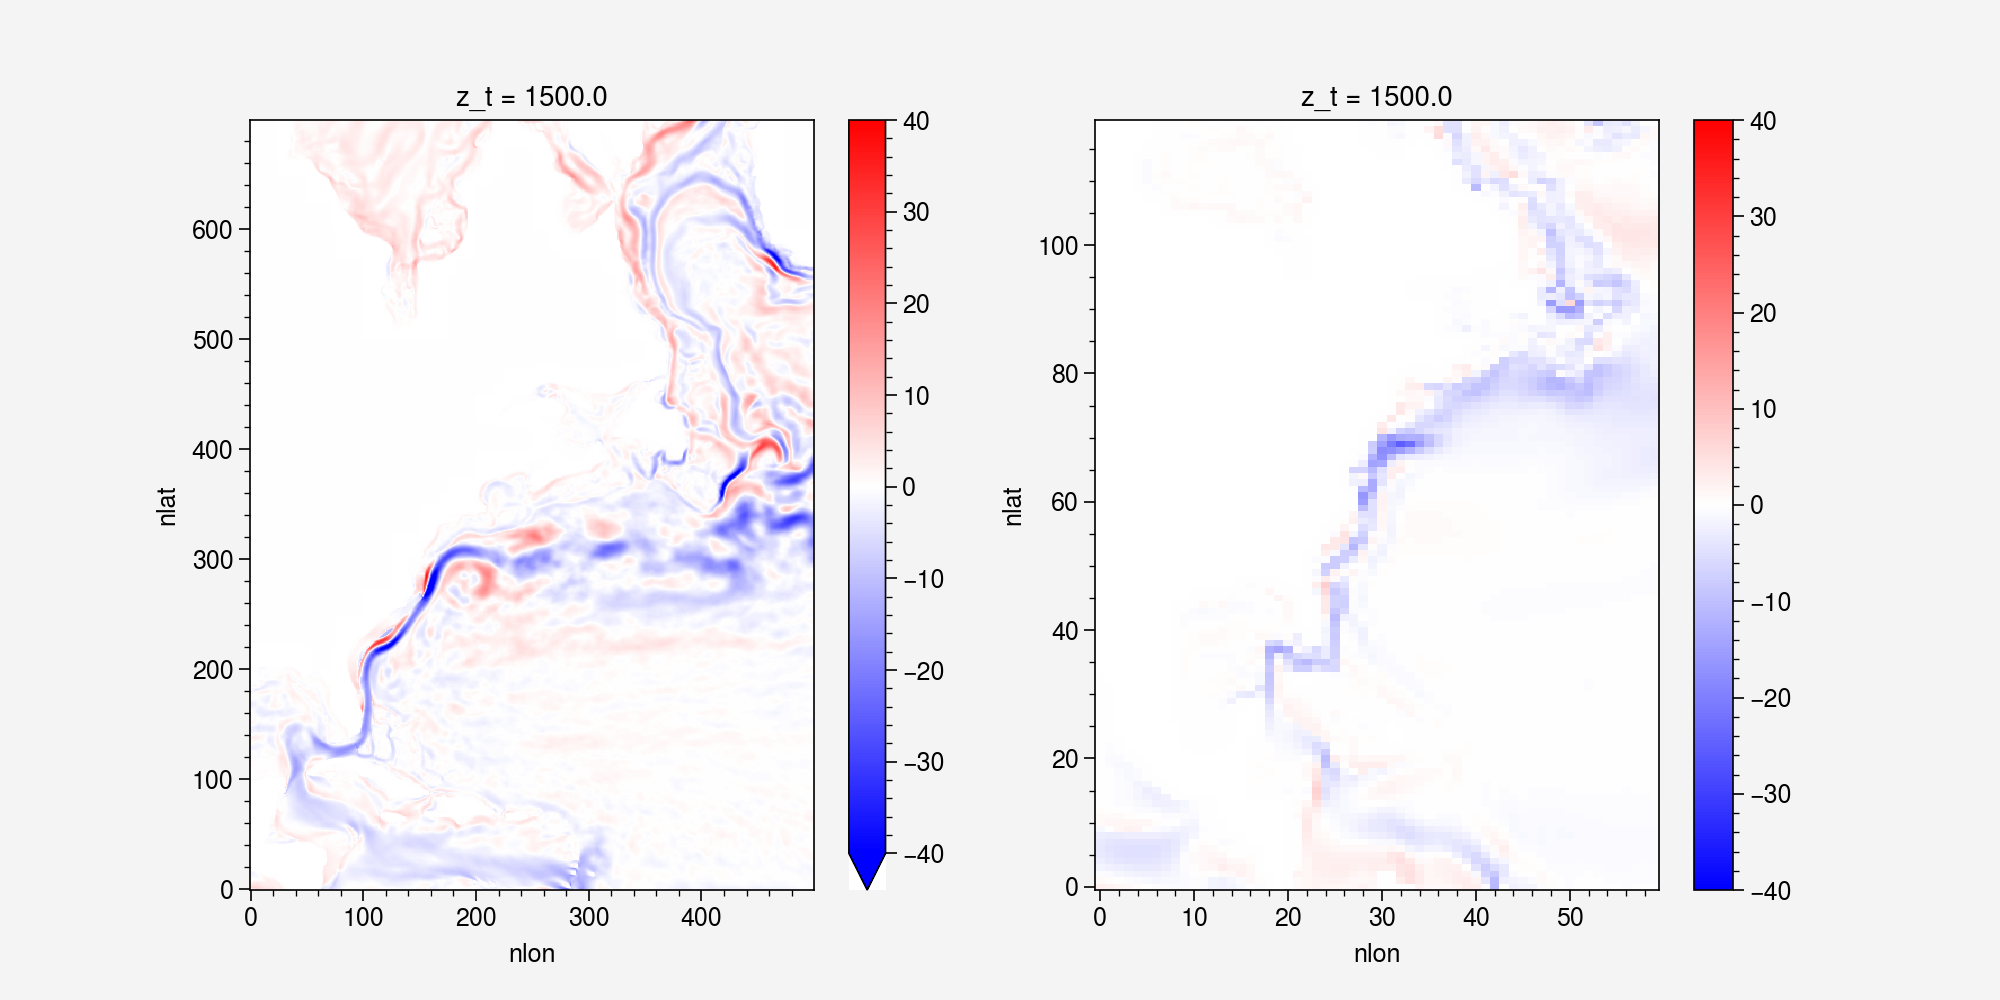

In [21]:
dspd_r_z_TH=spd_r_z_TH.sel(time=slice('2081','2100')).mean('time')-spd_r_z_TH.sel(time=slice('2001','2020')).mean('time')
dspd_r_z_CH=spd_r_z_CH.sel(time=slice('2081','2100')).mean('time')-spd_r_z_CH.sel(time=slice('2001','2020')).mean('time')
dspd_r_z_THmCH = dspd_r_z_TH - dspd_r_z_CH

dspd_r_z_TL=spd_r_z_TL.sel(time=slice('2081','2100')).mean('time')-spd_r_z_TL.sel(time=slice('2001','2020')).mean('time')
dspd_r_z_CL=spd_r_z_CL.sel(time=slice('2081','2100')).mean('time')-spd_r_z_CL.sel(time=slice('2001','2020')).mean('time')
dspd_r_z_TLmCL = dspd_r_z_TL - dspd_r_z_CL

fig, axs = plt.subplots(1,2,figsize=(10,5))
dspd_r_z_THmCH.plot(ax=axs[0],vmin=-40,vmax=40,cmap='bwr')
dspd_r_z_TLmCL.plot(ax=axs[1],vmin=-40,vmax=40,cmap='bwr')

# make pics

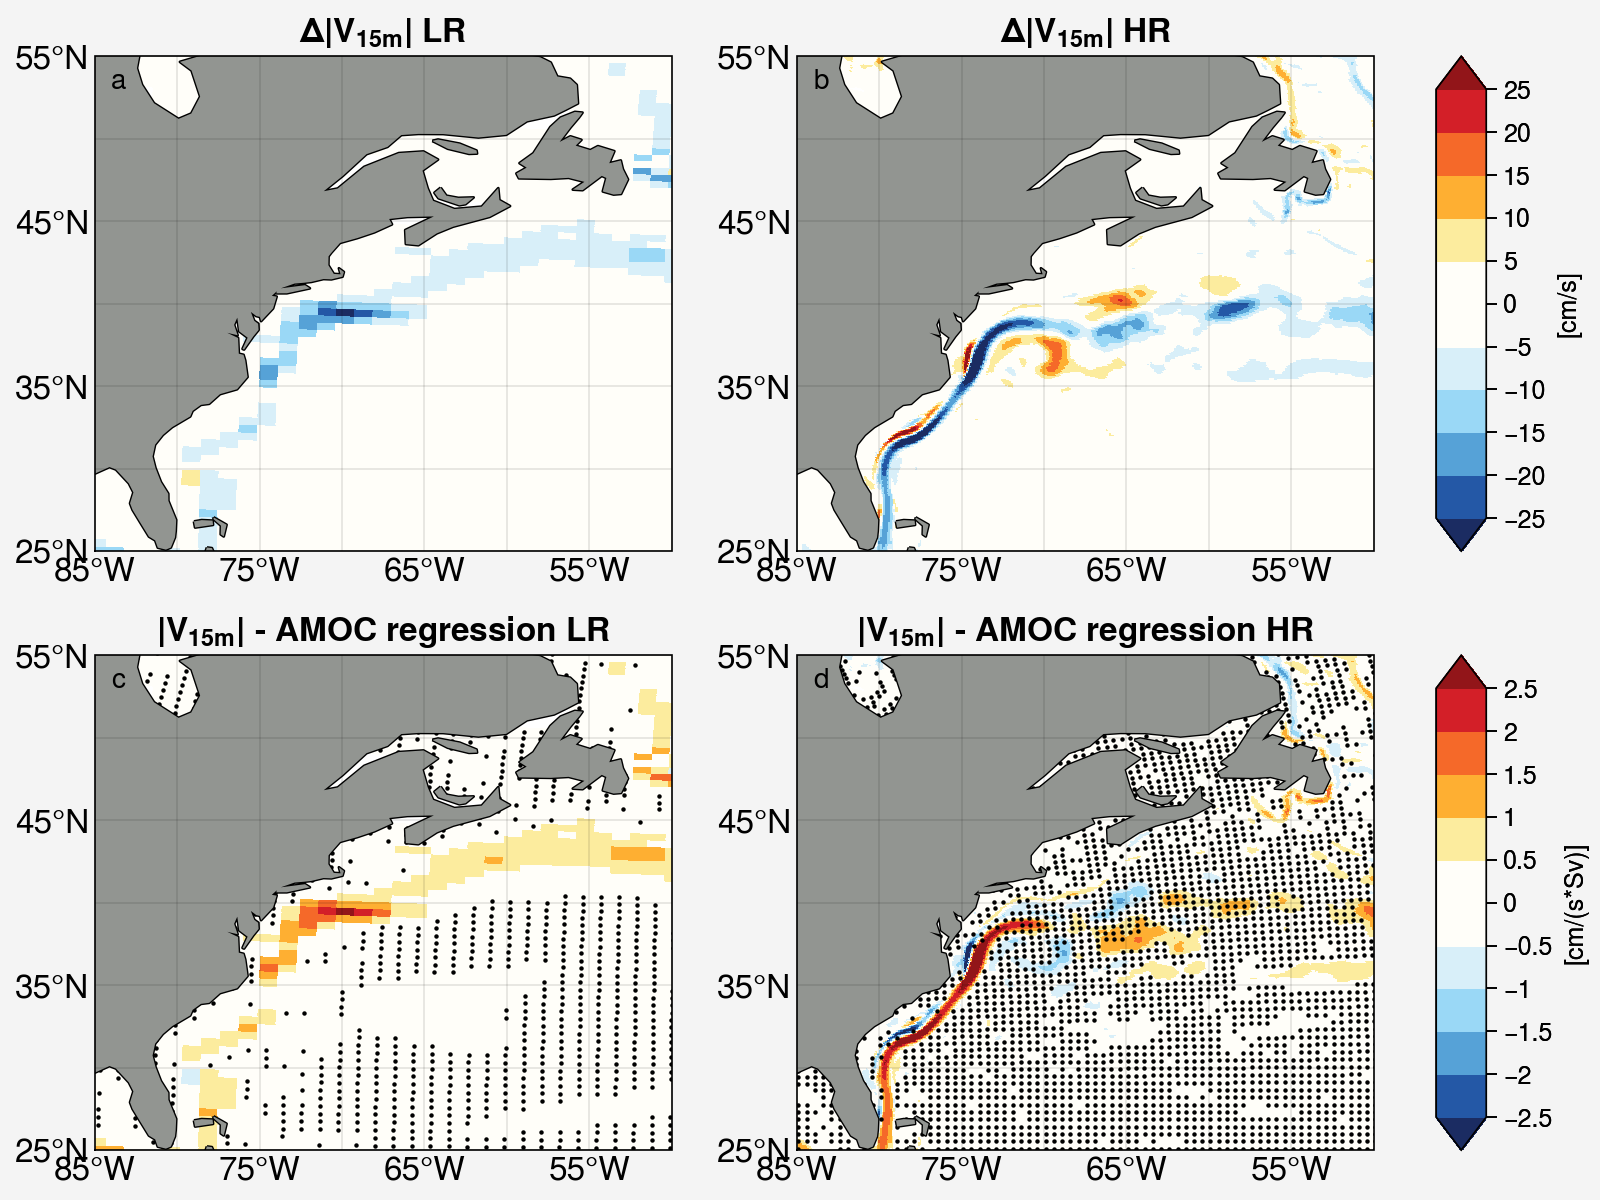

In [23]:
pc = cartopy.crs.PlateCarree()
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()

fig1, axs = plot.subplots(nrows=2,ncols=2,proj='cyl',width='8in',height='6in')

cut=-0.1

m00=axs[0,0].pcolormesh(ds_r_g16.ULONG, ds_r_g16.ULAT, 
        dspd_r_z_TLmCL, levels=np.arange(-25,25+1,5), transform=pc, 
        cmap="ColdHot", cmap_kw={'cut': cut}, extend='both')
# axs[0,0].plot(-71.1,42.2,transform=pc,marker='*',color='r',markersize=10)
# Boston (71.1W, 42.4N)
axs[0,0].coastlines(resolution='110m', color='black', linewidth=1)
axs[0,0].format(land=True, landcolor='grey')
axs[0,0].set_extent([lon1_r, lon2_r, lat1_r, lat2_r], crs=pc)
axs[0,0].set_xticks(np.arange(lon1_r,lon2_r+1,10), crs=pc)
axs[0,0].set_xticklabels(np.arange(lon1_r,lon2_r+1,10), fontsize=12)
axs[0,0].xaxis.set_major_formatter(lon_formatter)
axs[0,0].set_yticks(np.arange(lat1_r,lat2_r+1, 10), crs=pc)
axs[0,0].set_yticklabels(np.arange(lat1_r,lat2_r+1, 10), fontsize=12)
axs[0,0].yaxis.set_major_formatter(lat_formatter)
axs[0,0].set_title(r'$\Delta|V_{15m}|$ LR', fontsize=12, fontweight='bold')
axs[0,0].text(-84, 53, 'a', transform=pc, fontsize=10)

m01=axs[0,1].pcolormesh(ds_r_t12.ULONG, ds_r_t12.ULAT, 
        dspd_r_z_THmCH, levels=np.arange(-25,25+1,5), transform=pc, 
        cmap="ColdHot", cmap_kw={'cut': cut}, extend='both')
# axs[0,1].plot(-71.1,42.2,transform=pc,marker='*',color='r',markersize=10)
# Boston (71.1W, 42.4N)
axs[0,1].coastlines(resolution='110m', color='black', linewidth=1)
axs[0,1].format(land=True, landcolor='grey')
axs[0,1].set_extent([lon1_r, lon2_r, lat1_r, lat2_r], crs=pc)
axs[0,1].set_xticks(np.arange(lon1_r,lon2_r+1,10), crs=pc)
axs[0,1].set_xticklabels(np.arange(lon1_r,lon2_r+1,10), fontsize=12)
axs[0,1].xaxis.set_major_formatter(lon_formatter)
axs[0,1].set_yticks(np.arange(lat1_r,lat2_r+1, 10), crs=pc)
axs[0,1].set_yticklabels(np.arange(lat1_r,lat2_r+1, 10), fontsize=12)
axs[0,1].yaxis.set_major_formatter(lat_formatter)
axs[0,1].set_title(r'$\Delta|V_{15m}|$ HR', fontsize=12, fontweight='bold')
axs[0,1].text(-84, 53, 'b', transform=pc, fontsize=10)
cb = axs[0,1].colorbar(m01,loc='r',label='[cm/s]',width='2em',shrink=1)

m10=axs[1,0].pcolormesh(ds_r_g16.ULONG, ds_r_g16.ULAT, 
        spd2AMOC_r_TLmCL, levels=np.arange(-2.5,2.5+0.1,0.5), transform=pc, 
        cmap="ColdHot", cmap_kw={'cut': cut}, extend='both')
# axs[1,0].plot(-71.1,42.2,transform=pc,marker='*',color='r',markersize=10)
# Boston (71.1W, 42.4N)
axs[1,0].scatter(lonm_r_g16[::1,::1],latm_r_g16[::1,::1],transform=pc, marker='o',s=1,c='k')
axs[1,0].coastlines(resolution='110m', color='black', linewidth=1)
axs[1,0].format(land=True, landcolor='grey')
axs[1,0].set_extent([lon1_r, lon2_r, lat1_r, lat2_r], crs=pc)
axs[1,0].set_xticks(np.arange(lon1_r,lon2_r+1,10), crs=pc)
axs[1,0].set_xticklabels(np.arange(lon1_r,lon2_r+1,10), fontsize=12)
axs[1,0].xaxis.set_major_formatter(lon_formatter)
axs[1,0].set_yticks(np.arange(lat1_r,lat2_r+1, 10), crs=pc)
axs[1,0].set_yticklabels(np.arange(lat1_r,lat2_r+1, 10), fontsize=12)
axs[1,0].yaxis.set_major_formatter(lat_formatter)
axs[1,0].set_title(r'$|V_{15m}|$ - AMOC regression LR', fontsize=12, fontweight='bold')
axs[1,0].text(-84, 53, 'c', transform=pc, fontsize=10)
# cb = axs[1,0].colorbar(m10,loc='r',label='[cm/s]',width='2em',shrink=1)

m11=axs[1,1].pcolormesh(ds_r_t12.ULONG, ds_r_t12.ULAT, 
        spd2AMOC_r_THmCH, levels=np.arange(-2.5,2.5+0.1,0.5), transform=pc, 
        cmap="ColdHot", cmap_kw={'cut': cut}, extend='both')
# axs[1,1].plot(-71.1,42.2,transform=pc,marker='*',color='r',markersize=10)
# Boston (71.1W, 42.4N)
axs[1,1].scatter(lonm_r_t12[::5,::5],latm_r_t12[::5,::5],transform=pc, marker='o',s=1,c='k')
axs[1,1].coastlines(resolution='110m', color='black', linewidth=1)
axs[1,1].format(land=True, landcolor='grey')
axs[1,1].set_extent([lon1_r, lon2_r, lat1_r, lat2_r], crs=pc)
axs[1,1].set_xticks(np.arange(lon1_r,lon2_r+1,10), crs=pc)
axs[1,1].set_xticklabels(np.arange(lon1_r,lon2_r+1,10), fontsize=12)
axs[1,1].xaxis.set_major_formatter(lon_formatter)
axs[1,1].set_yticks(np.arange(lat1_r,lat2_r+1, 10), crs=pc)
axs[1,1].set_yticklabels(np.arange(lat1_r,lat2_r+1, 10), fontsize=12)
axs[1,1].yaxis.set_major_formatter(lat_formatter)
axs[1,1].set_title(r'$|V_{15m}|$ - AMOC regression HR', fontsize=12, fontweight='bold')
axs[1,1].text(-84, 53, 'd', transform=pc, fontsize=10)
cb = axs[1,1].colorbar(m11,loc='r',label='[cm/(s*Sv)]',width='2em',shrink=1)

fig1.savefig(pic1, bbox_inches='tight')

# Appendix

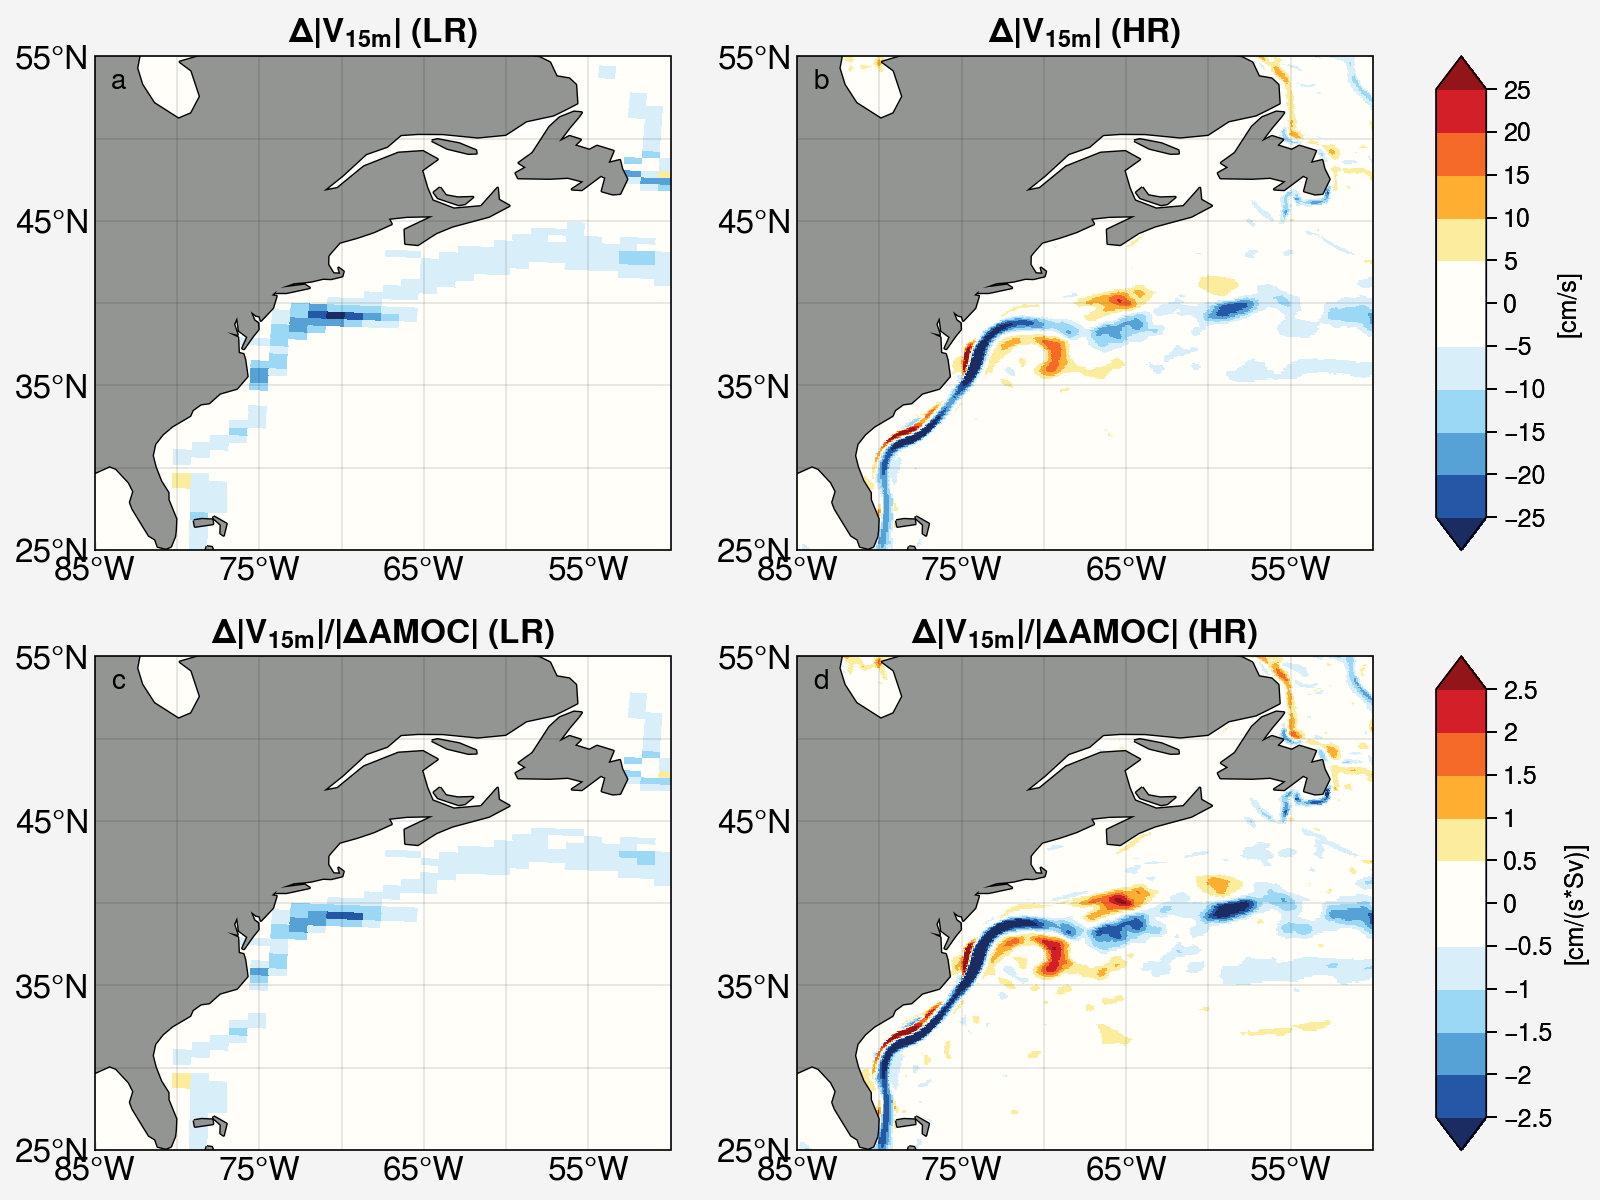

In [9]:
pc = cartopy.crs.PlateCarree()
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()

fig1, axs = plot.subplots(nrows=2,ncols=2,proj='cyl',width='8in',height='6in')

cut=-0.1

# m00=axs[0,0].pcolormesh(ds_r_g16.TLONG, ds_r_g16.TLAT, 
#         dspd_r_TLmCL, levels=np.arange(-25,25+1,5), transform=pc, 
#         cmap="ColdHot", cmap_kw={'cut': cut}, extend='both')
# # axs[0,0].plot(-71.1,42.2,transform=pc,marker='*',color='r',markersize=10)
# # Boston (71.1W, 42.4N)
# axs[0,0].coastlines(resolution='110m', color='black', linewidth=1)
# axs[0,0].format(land=True, landcolor='grey')
# axs[0,0].set_extent([lon1_r, lon2_r, lat1_r, lat2_r], crs=pc)
# axs[0,0].set_xticks(np.arange(lon1_r,lon2_r+1,10), crs=pc)
# axs[0,0].set_xticklabels(np.arange(lon1_r,lon2_r+1,10), fontsize=12)
# axs[0,0].xaxis.set_major_formatter(lon_formatter)
# axs[0,0].set_yticks(np.arange(lat1_r,lat2_r+1, 10), crs=pc)
# axs[0,0].set_yticklabels(np.arange(lat1_r,lat2_r+1, 10), fontsize=12)
# axs[0,0].yaxis.set_major_formatter(lat_formatter)
# axs[0,0].set_title(r'$\Delta|V_{15m}|$ (LR)', fontsize=12, fontweight='bold')
# axs[0,0].text(-84, 53, 'a', transform=pc, fontsize=10)

# m01=axs[0,1].pcolormesh(ds_r_t12.TLONG, ds_r_t12.TLAT, 
#         dspd_r_THmCH, levels=np.arange(-25,25+1,5), transform=pc, 
#         cmap="ColdHot", cmap_kw={'cut': cut}, extend='both')
# # axs[0,1].plot(-71.1,42.2,transform=pc,marker='*',color='r',markersize=10)
# # Boston (71.1W, 42.4N)
# axs[0,1].coastlines(resolution='110m', color='black', linewidth=1)
# axs[0,1].format(land=True, landcolor='grey')
# axs[0,1].set_extent([lon1_r, lon2_r, lat1_r, lat2_r], crs=pc)
# axs[0,1].set_xticks(np.arange(lon1_r,lon2_r+1,10), crs=pc)
# axs[0,1].set_xticklabels(np.arange(lon1_r,lon2_r+1,10), fontsize=12)
# axs[0,1].xaxis.set_major_formatter(lon_formatter)
# axs[0,1].set_yticks(np.arange(lat1_r,lat2_r+1, 10), crs=pc)
# axs[0,1].set_yticklabels(np.arange(lat1_r,lat2_r+1, 10), fontsize=12)
# axs[0,1].yaxis.set_major_formatter(lat_formatter)
# axs[0,1].set_title(r'$\Delta|V_{15m}|$ (HR)', fontsize=12, fontweight='bold')
# axs[0,1].text(-84, 53, 'b', transform=pc, fontsize=10)
# cb = axs[0,1].colorbar(m01,loc='r',label='[cm/s]',width='2em',shrink=1)

m10=axs[1,0].pcolormesh(ds_r_g16.TLONG, ds_r_g16.TLAT, 
        spd2AMOC_r_TLmCL, levels=np.arange(-2.5,2.5+0.1,0.5), transform=pc, 
        cmap="ColdHot", cmap_kw={'cut': cut}, extend='both')
# axs[1,0].plot(-71.1,42.2,transform=pc,marker='*',color='r',markersize=10)
# Boston (71.1W, 42.4N)
axs[1,0].coastlines(resolution='110m', color='black', linewidth=1)
axs[1,0].format(land=True, landcolor='grey')
axs[1,0].set_extent([lon1_r, lon2_r, lat1_r, lat2_r], crs=pc)
axs[1,0].set_xticks(np.arange(lon1_r,lon2_r+1,10), crs=pc)
axs[1,0].set_xticklabels(np.arange(lon1_r,lon2_r+1,10), fontsize=12)
axs[1,0].xaxis.set_major_formatter(lon_formatter)
axs[1,0].set_yticks(np.arange(lat1_r,lat2_r+1, 10), crs=pc)
axs[1,0].set_yticklabels(np.arange(lat1_r,lat2_r+1, 10), fontsize=12)
axs[1,0].yaxis.set_major_formatter(lat_formatter)
axs[1,0].set_title(r'$\Delta|V_{15m}|/ |\Delta AMOC|$ (LR)', fontsize=12, fontweight='bold')
axs[1,0].text(-84, 53, 'c', transform=pc, fontsize=10)
# cb = axs[1,0].colorbar(m10,loc='r',label='[cm/s]',width='2em',shrink=1)

m11=axs[1,1].pcolormesh(ds_r_t12.TLONG, ds_r_t12.TLAT, 
        spd2AMOC_r_THmCH, levels=np.arange(-2.5,2.5+0.1,0.5), transform=pc, 
        cmap="ColdHot", cmap_kw={'cut': cut}, extend='both')
# axs[1,1].plot(-71.1,42.2,transform=pc,marker='*',color='r',markersize=10)
# Boston (71.1W, 42.4N)
axs[1,1].coastlines(resolution='110m', color='black', linewidth=1)
axs[1,1].format(land=True, landcolor='grey')
axs[1,1].set_extent([lon1_r, lon2_r, lat1_r, lat2_r], crs=pc)
axs[1,1].set_xticks(np.arange(lon1_r,lon2_r+1,10), crs=pc)
axs[1,1].set_xticklabels(np.arange(lon1_r,lon2_r+1,10), fontsize=12)
axs[1,1].xaxis.set_major_formatter(lon_formatter)
axs[1,1].set_yticks(np.arange(lat1_r,lat2_r+1, 10), crs=pc)
axs[1,1].set_yticklabels(np.arange(lat1_r,lat2_r+1, 10), fontsize=12)
axs[1,1].yaxis.set_major_formatter(lat_formatter)
axs[1,1].set_title(r'$\Delta|V_{15m}| / |\Delta AMOC|$ (HR)', fontsize=12, fontweight='bold')
axs[1,1].text(-84, 53, 'd', transform=pc, fontsize=10)
cb = axs[1,1].colorbar(m11,loc='r',label='[cm/(s*Sv)]',width='2em',shrink=1)

# fig1.savefig(pic1, bbox_inches='tight')